In [1]:
import biom
import numpy as np
import pandas as pd
import qiime2 as q2
from Bio import SeqIO
from biom import Table
from scipy import stats
from gneiss.util import match
from collections import Counter
from skbio.diversity import alpha_diversity
pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

def parse_data(bt, mf, n_sample = 0, n_feature = 10):

    """
    Import data and filter
    by sum or reads/taxa

    filter cutoffs
    int, int
    """

    #match
    keep_subject = list(set(mf.index) & set(bt.ids()))
    bt.filter(keep_subject,axis='sample',inplace=True)
    # filter table by sum cutoffs
    keep_subject = bt.ids('sample')[bt.sum('sample') >= n_sample]
    keep_subject = list(set(mf.index) & set(keep_subject))
    bt.filter(keep_subject,axis='sample',inplace=True)
    # filter taxa
    keep_taxa = bt.ids('observation')[bt.sum('observation') > n_feature]
    # drop and filter
    bt.filter(keep_taxa,axis='observation',inplace=True)
    # df
    btdf = pd.DataFrame(bt.matrix_data.toarray(),
                        bt.ids('observation'),
                        bt.ids('sample'))
    # ensure matched 
    mf = mf.reindex(btdf.columns)

    return  bt, btdf, mf

def to_biom(df, loc, name):
    with biom.util.biom_open('%s/%s.biom'%(loc,name), 'w') as f:
        Table(df.values, df.index, df.columns).to_hdf5(f, name)
    return

def to_tsv(df, loc, name):
    df.index.name = '#SampleID'
    df.to_csv('%s/%s.tsv'%(loc,name), sep='\t')
    return 

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# build combined-ranks
DIABfl = q2.Artifact.load('../../data/DIABIMMUNE-Qiita-11884/q2-analysis/ctf-results/state_feature_ordination.qza')
ECAMfl = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/ctf-results/state_feature_ordination.qza')
DIABfl = DIABfl.view(q2.Metadata).to_dataframe().groupby('feature_id').sum()[['PC1']].sort_values('PC1')
ECAMfl = ECAMfl.view(q2.Metadata).to_dataframe().groupby('feature_id').sum()[['PC1']].sort_values('PC1')
# relabel ecam seqs
ecam_map = {rec.id : rec.seq for rec in SeqIO.parse('../../data/ECAM-Qiita-10249/rep-seqs.fa', "fasta")}
ECAMfl.index = [str(ecam_map[x]) for x in ECAMfl.index]
# ranks
ranking_biomark = pd.concat([DIABfl, ECAMfl], axis=1, sort=False).dropna()
ranking_biomark.columns = ['DIAB', 'ECAM']
ranking_biomark = ranking_biomark.rank()
ranking_biomark['rank'] = ranking_biomark.mean(1)
ranking_biomark.index.name = 'featureid'
ranking_biomark['feature_id'] = ranking_biomark.index
# save the rankings
ranking_biomark.to_csv('../../data/data-assests/all-biomarker-ranks.tsv',sep='\t')


In [3]:
## load AG data
btag = biom.load_table('../../data/AG-data/deblur_125nt_no_blooms.biom')

# import metadata and add birth-mode
mfag = pd.read_csv('../../data/AG-data/ag_map_with_alpha.txt',
                 sep='\t',index_col=0, low_memory=False)

# add birth mode
mfag['birth_mode'] = mfag['csection'].replace({'Not sure':np.nan,
                                               'Unspecified':np.nan,})
mfag['birth_mode'] = mfag['birth_mode'].replace({'Yes':'C-section',
                                                 'No':'Vaginal',
                                                 'false':'Vaginal',
                                                 'true':'C-section'})
mfag['age_cat'] = mfag['age_cat'].replace({'Unspecified':np.nan,
                                           'Not provided':np.nan})
mfag['age_years'] = mfag['age_years'].replace({'Unspecified':np.nan,
                                               'Not provided':np.nan})
mfag['age_corrected'] = mfag['age_corrected'].replace({'Unspecified':np.nan,
                                                       'Not provided':np.nan})
mfag = mfag[~mfag['age_cat'].isin(['70+'])]

# corrected ages (to help N balance)
mfag = mfag.replace({'Baby':'0-3',
                     'Child':'4-12',
                     'Teen':'13-19'})
mfag['age_groups'] = mfag['age_cat'].replace({'0-3':'Age (years) <= 3', 
                                              '13-19':'Age (years) >= 4',
                                              '20s':'Age (years) >= 4',
                                              '30s':'Age (years) >= 4',
                                              '4-12':'Age (years) >= 4',
                                              '40s':'Age (years) >= 4',
                                              '50s':'Age (years) >= 4',
                                              '60s':'Age (years) >= 4'})

### bin ages
age_group = {'placeholder':0,
             '0-3':4,
             '4-12':13,
             '13-19':20,
             '20s':30,
             '30s':40,
             '40s':50,
             '50s':60,
             '60s':70,
             '70+':150}
bins_ = ['placeholder',
         '0-3', '4-12', '13-19',
         '20s', '30s', '40s',
         '50s', '60s',
         '70+']

age_binned = []
mfag['age_years_float'] = mfag.age_years.astype(float)
for age_year_ in mfag.age_years.astype(float):
    if np.isnan(age_year_):
        age_binned.append(np.nan)
        continue
    for bin_i, bin_ in enumerate(bins_[:-1]):
        if age_year_ in range(age_group[bins_[bin_i]], age_group[bins_[bin_i+1]]):
            age_binned.append(bins_[bin_i+1])
mfag['age_binned'] = age_binned


# filter data
btmatch_ag, btdf_ag, mf_ag = parse_data(btag.copy(), mfag.copy())

# get and match ranks
ranking_biomark['nt125'] = [fid[:-25] for fid in ranking_biomark.feature_id]
rank_common = set([fid for fid in ranking_biomark.nt125]) & set(btdf_ag.index)
# view metadata
mf_ag.head(5)


,barcode,center_name,center_project_name,comments_renamed,condition_renamed,experiment_center,experiment_design_description,experiment_title,extraction_robot,extractionkit_lot,...,observed_otus_1250,faiths_pd_1250,shannon_1250,observed_otus_2500,faiths_pd_2500,shannon_2500,birth_mode,age_groups,age_years_float,age_binned
10317.000054127,CGTGAGGACCAG,UCSDMI,AGag33,Unspecified,Unspecified,UCSDMI,"fecal, saliva, skin and environment samples fr...",American Gut Project,HOWE_KF1,PM16B24,...,85.5,11.281929,4.620716,102.0,12.591806,4.615221,Vaginal,Age (years) >= 4,3.0,0-3
10317.000030973,TCGAGAGTTTGC,UCSDMI,AG21,Unspecified,Unspecified,UCSDMI,"fecal, saliva and skin samples from the Americ...",American Gut Project,HOWE,PM15G7,...,78.4,9.664061,4.103576,93.1,10.716395,4.114143,Vaginal,Age (years) >= 4,33.0,30s
10317.000069160,ACACGCGGTTTA,UCSDMI,AGagFerm,Unspecified,Unspecified,UCSDMI,"fecal, saliva, skin and environment samples fr...",American Gut Project,CARMEN_KF1,154050095,...,100.5,11.209730,4.712811,125.3,12.871773,4.801569,Vaginal,Age (years) >= 4,57.0,50s
10317.000059092,ATTGCCTTGATT,UCSDMI,AGag33,Unspecified,Unspecified,UCSDMI,"fecal, saliva, skin and environment samples fr...",American Gut Project,HOWE_KF1,PM16B24,...,83.1,10.950799,2.842364,101.0,12.340298,2.881495,Vaginal,Age (years) >= 4,19.0,13-19
10317.000003303,CGTCGTCTAAGA,UCSDMI,AG10,Unspecified,Unspecified,UCSDMI,"fecal, saliva and skin samples from the Americ...",American Gut Project,NEWE,PS14C91,...,131.3,15.380801,5.554152,167.9,18.479535,5.684329,Vaginal,NaN,NaN,NaN


### take log-ratio

In [6]:
n=532
ranking_biomark_subset = ranking_biomark[ranking_biomark['nt125'].isin(rank_common)]
ranking_biomark_subset.index = ranking_biomark_subset.nt125
rank_ = ranking_biomark_subset.copy().sort_values('rank')
numerator = rank_.index[:n]
denominator = rank_.index[-n:]

numlr = np.log(btdf_ag.loc[numerator,:].sum(axis=0))
denlr = np.log(btdf_ag.loc[denominator,:].sum(axis=0))
lr = numlr - denlr
lr[~np.isfinite(lr)] = np.nan
lrdf = pd.DataFrame(lr, columns=['logratio']).dropna(subset=['logratio'])
mflr = mf_ag.loc[lrdf.index,:]
mflr['logratio'] = lrdf['logratio']
palfor = {'Vaginal':'#377eb8','C-section':'#ff7f00'}
mflr = mflr.groupby('host_subject_id').agg({'logratio':'mean',
                                            'country':'first',
                                            'country_of_birth':'first',
                                            'subset_ibd':'first',
                                            'subset_healthy':'first',
                                            'birth_mode':'first',
                                            'ibd':'first',
                                            'observed_otus_1250':'mean',
                                            'faiths_pd_1250':'mean',
                                            'shannon_1250':'mean',
                                            'observed_otus_2500':'mean',
                                            'faiths_pd_2500':'mean',
                                            'shannon_2500':'mean',
                                            'diabetes_type':'first',
                                            'age_binned':'first',
                                            'age_years':'first'})
mflr_plt = mflr[~mflr.age_binned.isin(['Unspecified', np.nan, '70+'])]
ordr = {'0-3':0,'4-12':1,'13-19':2}
agord = {'20s':1, '30s':2, '40s':3, '50s':4, '60s':5, '70+':6}
agord = {k:v+np.max(list(ordr.values())) for k,v in agord.items()}
agord = {**ordr,**agord}
mflr_plt['ageord'] = [agord[x] for x in mflr_plt.age_binned]
palfor = {'Vaginal':'#377eb8','C-section':'#ff7f00'}


### make binned age comparisons

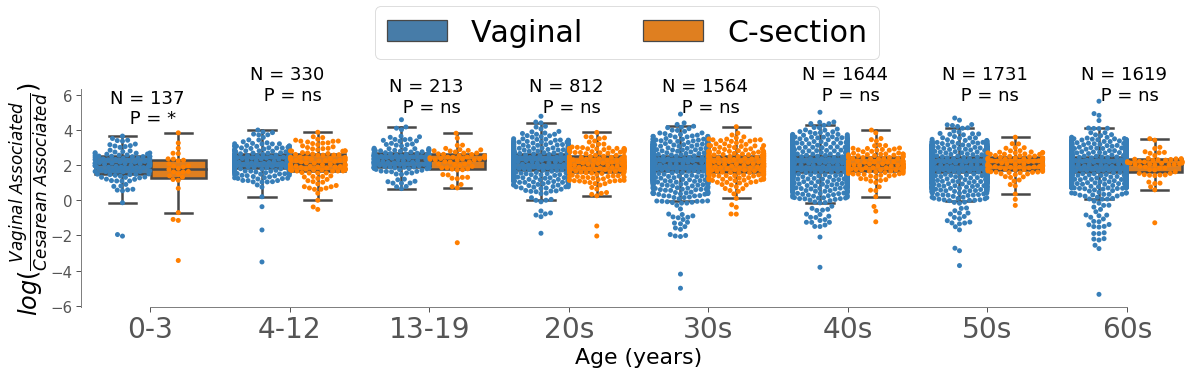

In [11]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2.5, 
            'lines.markersize': 14}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 15

ys = [.15, 0.8, 0.8, 0.8,
      1.5, 1.5, 1.5, 1.5]

fig, ax = plt.subplots(1,1,figsize=(20,4), sharex=True, sharey=False)

# Lineplot across time 
""" 
sns.boxenplot(x='age_binned',
                 y='logratio',
                 hue='birth_mode',
                 palette=palfor,
                 data=mflr_plt.sort_values('ageord'),
                 ax=ax,
                outlier_prop=1e-40)
"""
sns.boxplot(x='age_binned',
                 y='logratio',
                 hue='birth_mode',
                 palette=palfor,
                 whis = 2, 
                 data=mflr_plt.sort_values('ageord'),
                 ax=ax, showfliers=False)

sns.swarmplot(x='age_binned',
                 y='logratio',
                 hue='birth_mode',
                 dodge=True,
                 palette=palfor,
                 data=mflr_plt.sort_values('ageord'),
                 ax=ax)

for x_, (t_, tdf) in enumerate(mflr_plt.groupby('age_binned')):

    t_tes,p_ = stats.ttest_ind(tdf[tdf.birth_mode.isin(['Vaginal'])]['logratio'].values, 
                            tdf[tdf.birth_mode.isin(['C-section'])]['logratio'].values) 
    if np.around(p_,3) <= .001:
        p_ = "***"
    elif np.around(p_,2) <= 0.01:
        p_ = "**"
    elif np.around(p_,2) < 0.05:
        p_ = "*"
    else:
        p_ = "ns"
    # add stats
    y = ys[x_]
    x_ = agord[t_]      
    h = 4
    ax.text(x_, y+h, "N = %i \n P = %s"%(tdf.shape[0], p_),
            ha='center', va='bottom',
            color='#000000', fontsize=18)

# add labels
ax.set_xlabel('Age (years)', color='#000000',
              fontsize=22)
y_label = ('$log(\\frac{Vaginal\,\,Associated}'
           '{Cesarean\,\,Associated})$')
ax.set_ylabel(y_label, color='#000000',
              fontsize=24, labelpad=0)

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(0,7)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

ax.set_xlim(-.5,)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2],
            prop={'size':30}, loc=2, 
            bbox_to_anchor=(.25, 1.45),
            fancybox=True, framealpha=0.8,ncol=2
            , markerscale=1.1, facecolor="white")

# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(6.0)

# save the figure to file
plt.savefig('../../results/AG-log-ratio-by-age-years-binned.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()
